# Описание проекта

Сервис  “Мой Чемпион” помогает спортивным школам фигурного катания, тренерам мониторить результаты своих подопечных и планировать дальнейшее развитие спортсменов.

## Цель

Создать модель, помогающую находить элементы, которые могут быть успешно исполнены спортсменом на соревновании. 
Сервис будет прогнозировать прогресс и возможное выполнение тех или иных элементов программы по истории предыдущих выступлений и выполнения элементов на соревнованиях.

## Задачи 

Объединить данные – спортсмены, юниты, соревнования, сегменты, школы, тренеры

Провести анализ данных, изучить аномалии, корреляции, описать наблюдения и сделать выводы
Выделить все элементы фигурного катания, представленых в виде объединенной строки с набором элементов например 2F!<<+2Lo<<CCoSp2V*

Актуальный список элементов можно посмотреть здесь https://eislauf-union.de/files/users/997/Elemente-Liste2023_24.pdf вам нужна будет только категория Single skating, а также специальные отметки Special codes в конце документа

Выделить элементы успешно выполненные и с погрешностями (имеют специальные пометки)

Агрегировать датасет и подготовить обучающие признаки

Создать модель для предсказания вероятности успешного выполнения элементов

Проанализировать признаки, выявить ошибки и слабые стороны модели, улучшить решение



In [ ]:
import numpy as np 
import pandas as pd 

import os
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer

С помощью библиотек начинаем работать с небходимыми данными.

In [2]:
scores = pd.read_csv('/kaggle/input/my-champion/tournament_scores.csv')
tournament = pd.read_csv('/kaggle/input/my-champion/tournaments.csv')
units = pd.read_csv('/kaggle/input/my-champion/units.csv')
total = pd.read_csv('/kaggle/input/my-champion/total_scores.csv')

Смотрим и анализируем данные.

In [3]:
def describe_df(df):
    display(df.head().T)
    print('-----------------------------------------------------------------------------------------------')
    display(df.info())
    print('-----------------------------------------------------------------------------------------------')
    display(df.describe())
    print('-----------------------------------------------------------------------------------------------')
    display(f'Number of duplicates: {df.duplicated().sum()}')

<Axes: >

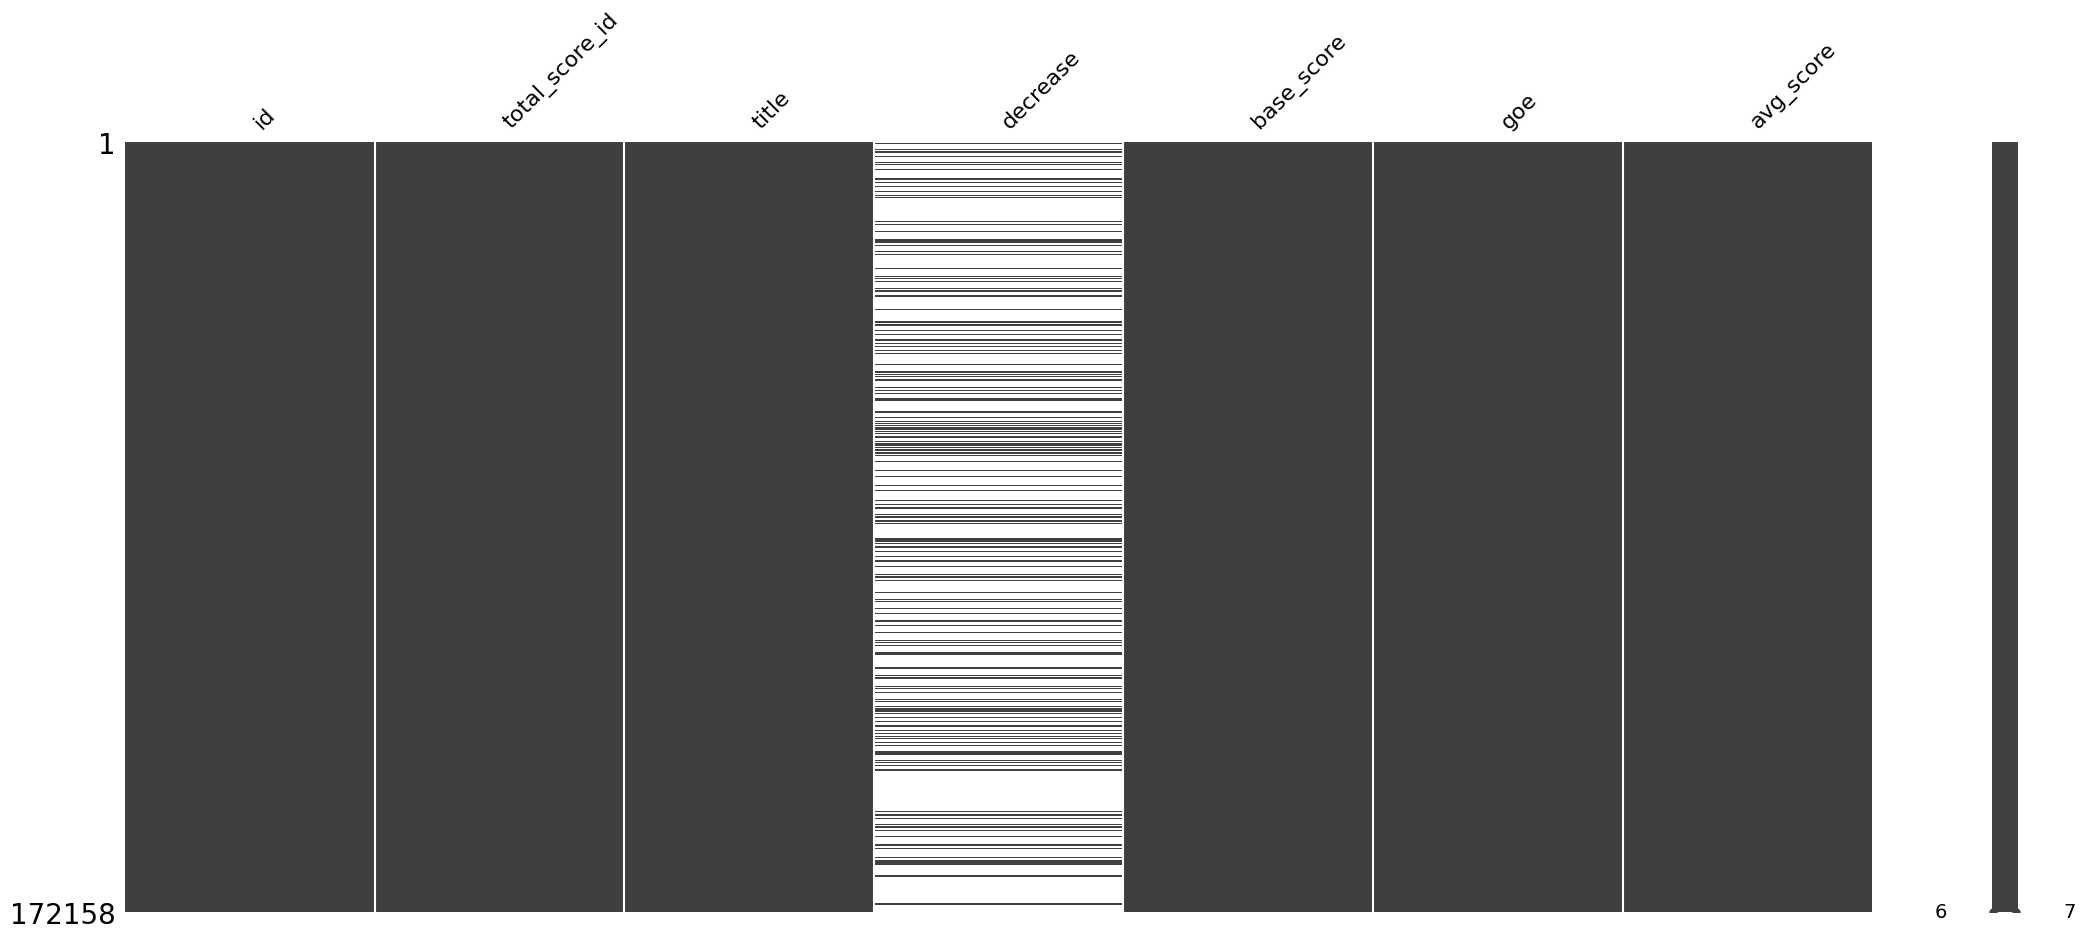

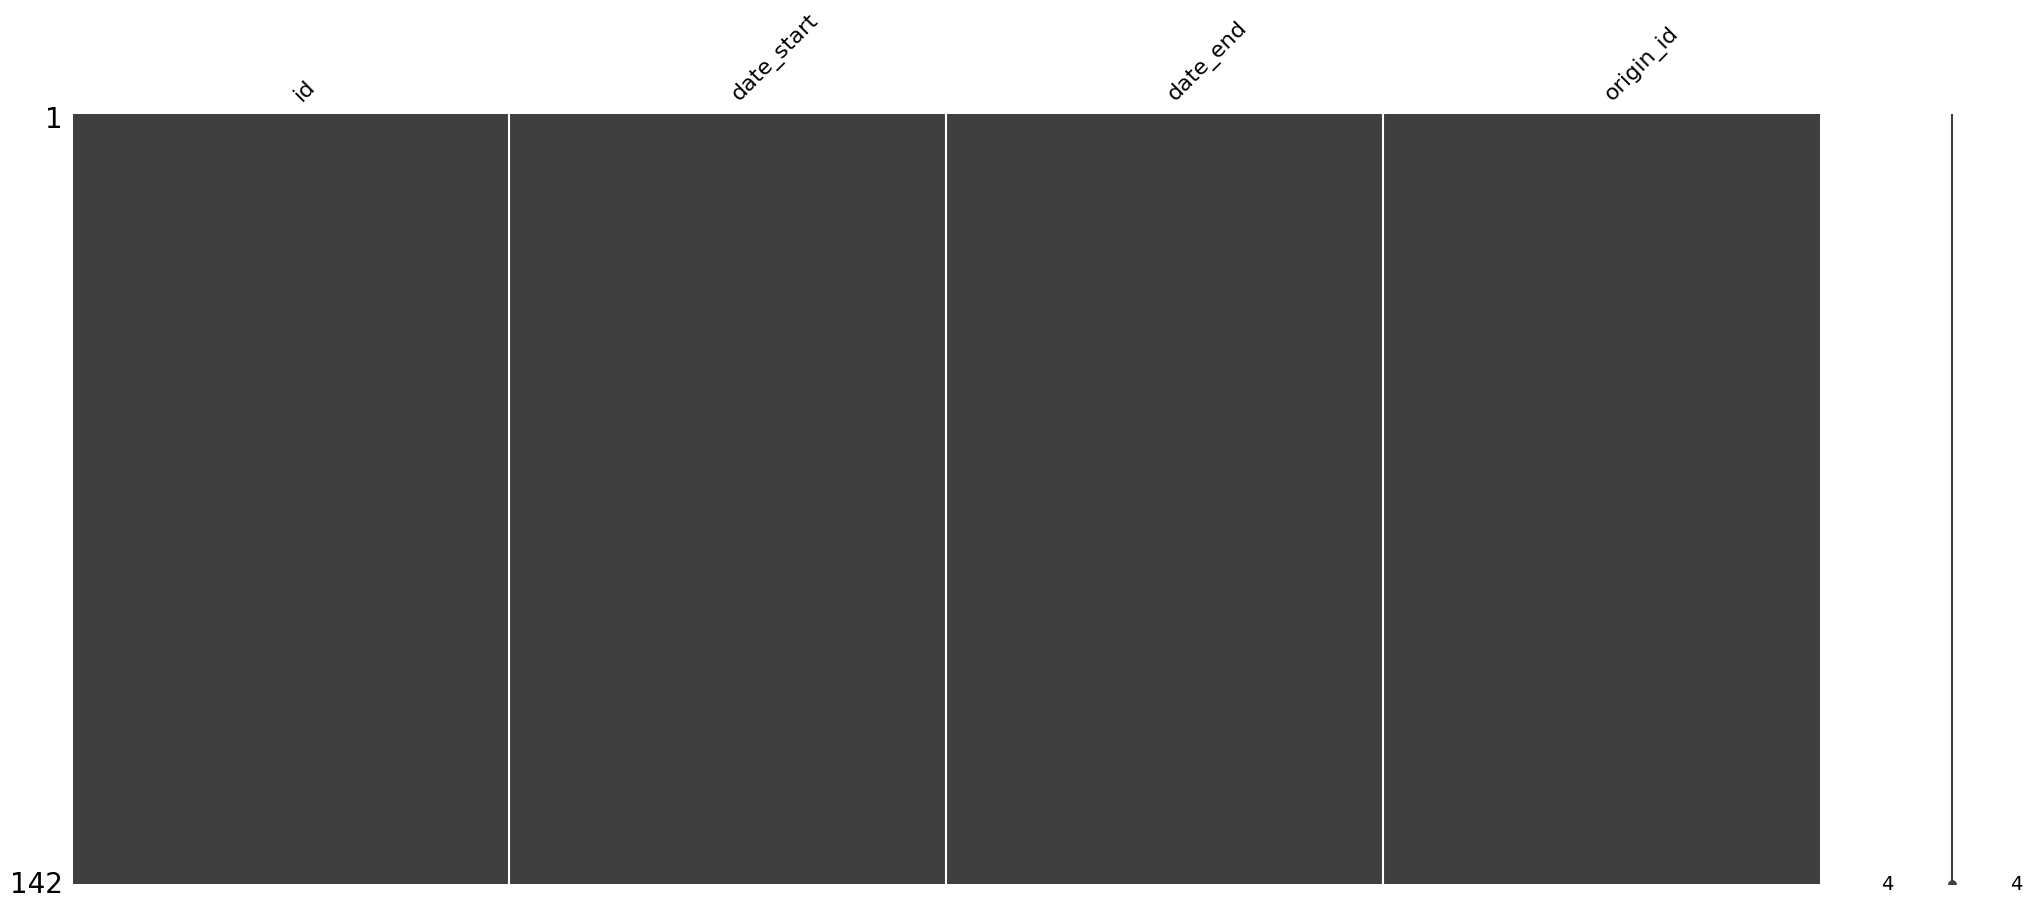

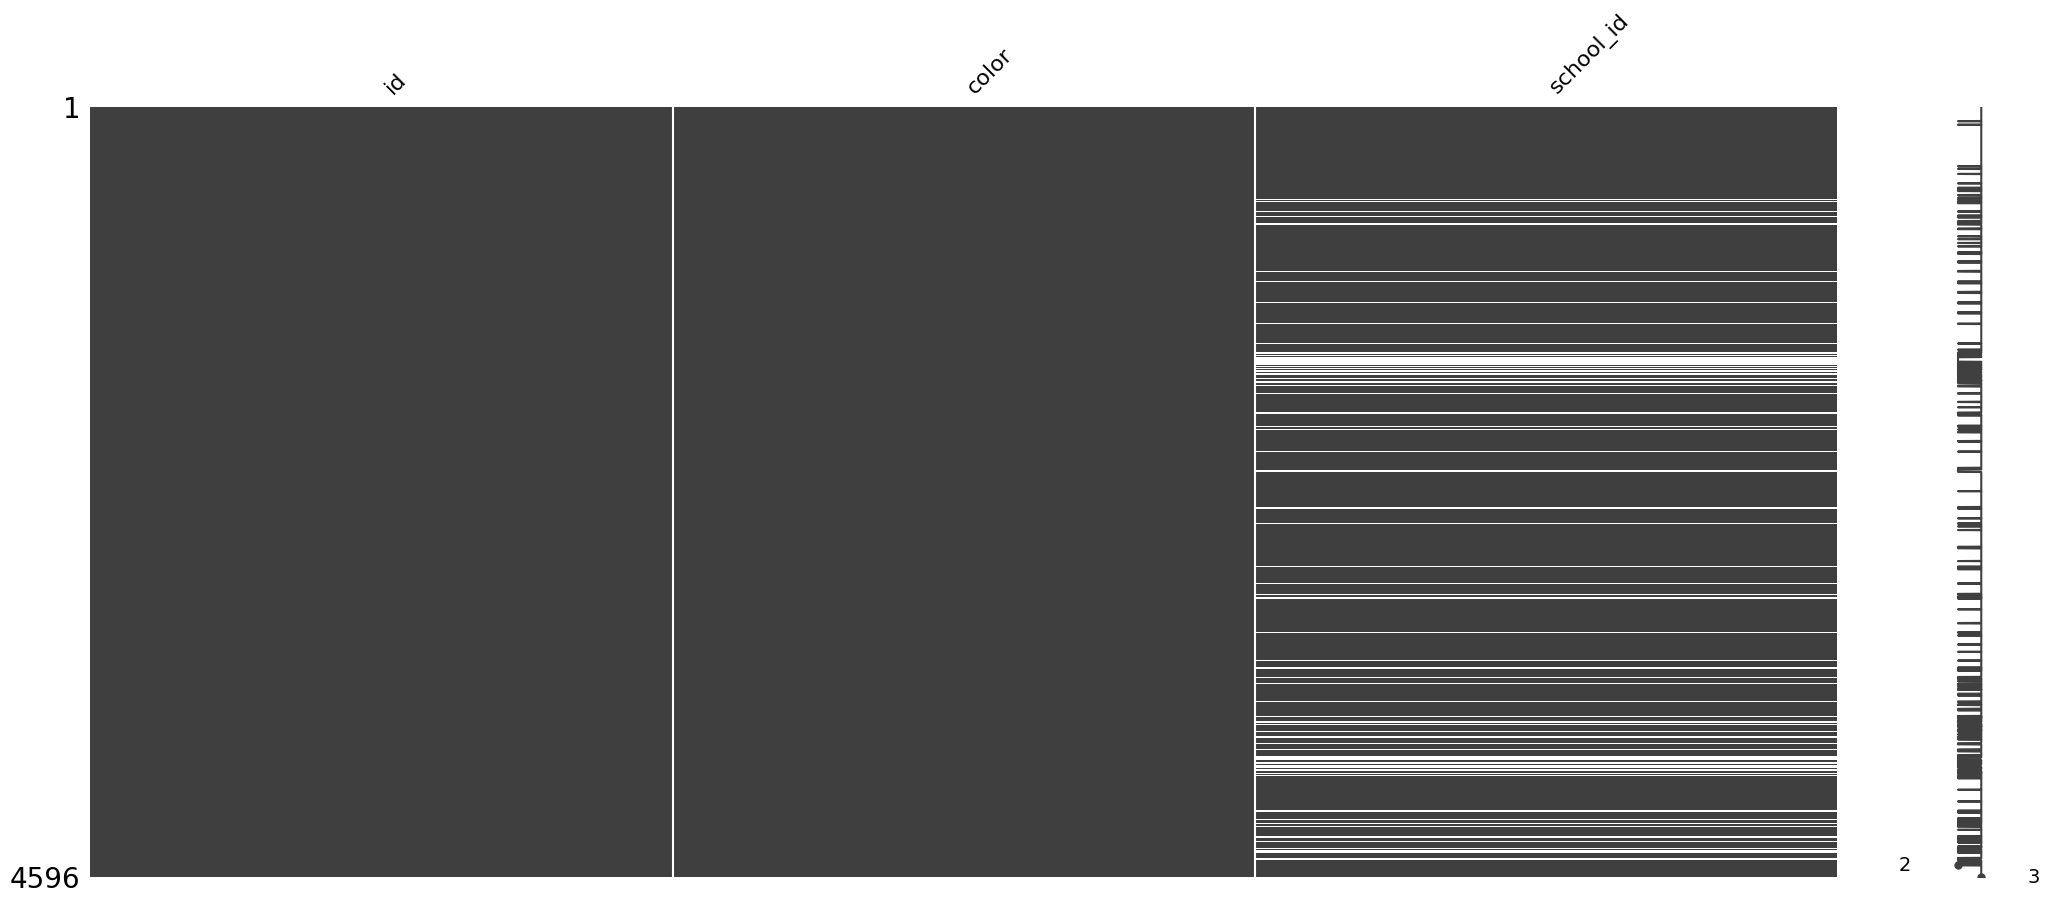

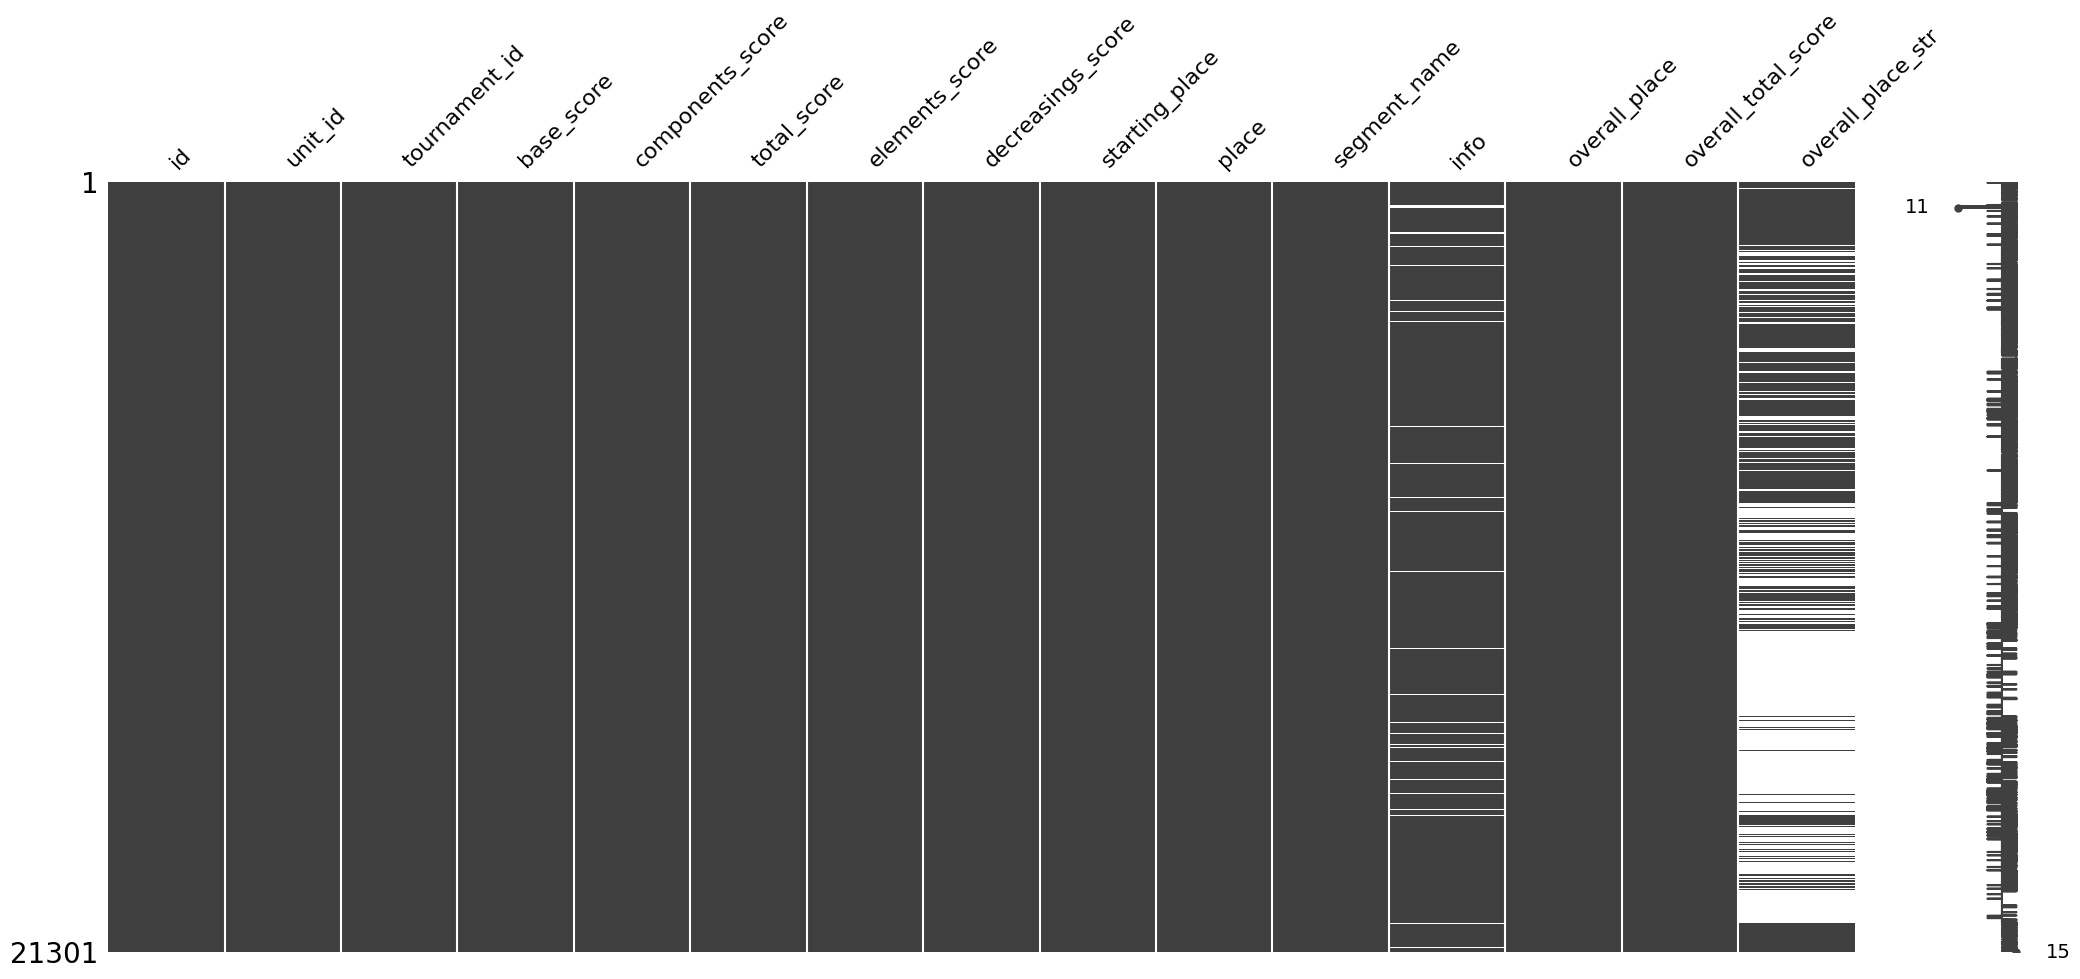

In [5]:
msno.matrix(scores)
msno.matrix(tournament)
msno.matrix(units)
msno.matrix(total)

Вывод:
- в данных есть пропуски и пустые значения;
- данные необходимо объеденить в один датасет.

In [6]:
for col in scores.columns:
    print(col, '-->', len(col), '-->', scores[col].unique())

id --> 2 --> [     1      2      3 ... 352010 352011 352012]
total_score_id --> 14 --> [     1      8     19 ... 463405 463406 463407]
title --> 5 --> ['2A' '3F+3Lo' '3Lz' ... '2Lz!q+1Lo*' '2Lz!q+2T<<' '2S*+1A*+SЕQ']
decrease --> 8 --> [nan 'q' '<' '!' '<<' 'nS' 'F' '*' 'e' 'nU' 'nC' '<<*' '<*' 'B' 'nS*' '!F'
 'F*' '!*' 'q*' 'e*' 'nF' 'nB' 'B.' 'f*' 'В' '<F' 'qF' 'b' '!<' 'f' '!F*'
 'FnU' 'FF']
base_score --> 10 --> [ 3.3  10.2   0.    3.5   3.2   2.7   2.6   7.02  3.    4.9   5.3   5.9
 10.8   1.8   9.82  5.5   2.25  2.3   1.7   4.3   5.6   6.    2.4   1.3
  8.    9.5  10.7   9.8   8.1   2.1   2.8   6.2   7.2   3.6   4.74  4.2
  2.5   2.    4.6   1.1   3.4   1.88  1.44  1.5   0.5   7.5   3.92  4.44
  5.1   3.44  3.43  3.8   4.4   2.64  3.46  4.1   0.91  2.98  1.9   2.34
  1.73  9.9  10.1   2.63  7.6   3.1   5.    1.4   1.19  4.72  0.4   3.7
  6.6   8.4   3.36  6.5   1.2   3.71  8.2   8.52  6.02  2.74  1.36  2.14
  1.04  3.94  3.16  9.26  6.74  1.6   5.62 11.9   4.13  6.44  0.48  1.
  

In [7]:
for col in tournament.columns:
    print(col, '-->', len(col), '-->', tournament[col].unique())

id --> 2 --> [   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   21   22   23   24   25   26   28   29
   30   31   33   34   35   36   37   38   39   40   41   42   43   44
   45   46   47   48   49   50   51   52   68   69   72   73   74   75
   76   77   78   79   80   82   83   84   85   86   87   88   91   92
   93   94   95  176  177  222  351  263  267  398  293 1917 2283 3239
 3593 4785 4790 4789 4793 4794 4862 4865 4844 4992 5459 5859 5860 6150
 6159 6160 6842 6844 2616 6310 6847 6848 6850 6851 6854 6852 6849 6859
 6860 6864 6866 6867 5883 5879 6869 6884 6885 7092 7093 6845 6682 6696
 6698 6699 6700 7098 7104 7106 7103 7110 7112 7109 7111 7114 7116 7117
 7115 6676]
date_start --> 10 --> ['2090-11-29' '2091-03-06' '2090-10-05' '2090-10-18' '2090-10-21'
 '2090-10-26' '2090-10-28' '2090-11-02' '2090-11-04' '2090-11-08'
 '2090-11-11' '2090-11-16' '2090-11-18' '2090-11-22' '2090-11-23'
 '2090-11-28' '2090-12-09' '2090-12-16' '2090

In [8]:
for col in units.columns:
    print(col, '-->', len(col), '-->', units[col].unique())

id --> 2 --> [9474  733  734 ... 5109 5110 5113]
color --> 5 --> ['green' 'lime' nan]
school_id --> 9 --> [2.4400e+02 2.0300e+02 2.3500e+02 1.6800e+02 1.1800e+02 1.9700e+02
 2.2500e+02 5.1000e+01 9.0000e+01 2.0100e+02 2.3300e+02 2.7000e+01
 2.0900e+02 1.9800e+02 9.4000e+01 2.5700e+02 6.2000e+01 1.1100e+02
 3.8000e+01 4.9000e+01 9.3000e+01 2.8400e+02 2.5000e+01 2.4900e+02
 9.2000e+01 1.2800e+02 7.6000e+01 2.3800e+02 8.7000e+01 1.4400e+02
 1.5000e+01 9.6000e+01 7.0000e+00 2.5400e+02 1.1700e+02 8.5000e+01
 1.6900e+02 1.3500e+02 9.9999e+04 1.2300e+02 2.6500e+02        nan
 2.0500e+02 1.9300e+02 1.7200e+02 1.7600e+02 4.0000e+01 1.9400e+02
 2.0000e+02 2.5300e+02 1.2200e+02 2.4000e+01 1.9000e+02 1.9900e+02
 6.0000e+00 1.0500e+02 2.7400e+02 2.7000e+02 7.5000e+01 7.2000e+01
 6.7000e+01 2.1200e+02 2.5200e+02 8.2000e+01 2.5600e+02 2.6000e+01
 1.2900e+02 4.2000e+01 1.8400e+02 1.9600e+02 1.2400e+02 1.8000e+01
 4.7000e+01 8.6000e+01 1.0800e+02 1.8000e+02 2.1000e+01 6.4000e+01
 2.4600e+02 1.5400e+02 

In [9]:
for col in total.columns:
    print(col, '-->', len(col), '-->', total[col].unique())

id --> 2 --> [442027 442028 442029 ... 462407 462408 462409]
unit_id --> 7 --> [  304   604   409 ...  4384 34980 34981]
tournament_id --> 13 --> [4785   88    1 6864 4865    2 5459 6885   77 4992   22   24   73 7092
    3   23    4 3239 7114 4862    5    6 4844 5879 4794    7   69    8
 4793    9   10   11   12 4789   14 5860   15 5859   16   17  267   18
   39 5883   19 2616   20   21  398   34   80   25   82   26   28   29
   30   33   31  263   35 3593   36   78  177   37   38   95 6848   72
   40   91   41   42   76   79   85   92   43   83   68   44 4790 7115
   74   47   45   93   94   46 6866 1917   48 6867 6676   49 6150 6699
   50   51 6159 6160   52 6696 7109 6682 6849 6698 2283   75 7116 6700
  222 7110 7117  351 6842 6847 6844   84 6845 6869   86   87 6850 6859
 6851  176 7106 6860 6310   13 7093 7103 7104 7111 6884  293 7112 7098
 6852 6854]
base_score --> 10 --> [47.2  45.4  44.   ... 41.18 10.37  9.51]
components_score --> 16 --> [43.47 46.71 46.82 ... 50.26 17.27 43.56

In [10]:
units = units.rename(columns ={'id':'unit_id'})

In [11]:
tournament = tournament.rename(columns ={'id':'tournament_id'})

In [12]:
df_total = total.merge(units, how ='inner', on ='unit_id')

In [13]:
df_total = df_total.merge(tournament, how ='inner', on ='tournament_id')

In [14]:
df_total = df_total.rename(columns ={'id':'total_score_id'})

In [15]:
df_total = df_total.merge(scores, how ='inner', on ='total_score_id')

In [16]:
describe_df(df_total)

,0,1,2,3,4
total_score_id,442027,442027,442027,442027,442027
unit_id,304,304,304,304,304
tournament_id,4785,4785,4785,4785,4785
base_score_x,47.2,47.2,47.2,47.2,47.2
components_score,43.47,43.47,43.47,43.47,43.47
total_score,102.7,102.7,102.7,102.7,102.7
elements_score,59.23,59.23,59.23,59.23,59.23
decreasings_score,0.0,0.0,0.0,0.0,0.0
starting_place,17,17,17,17,17
place,1,1,1,1,1


-----------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   total_score_id       172158 non-null  int64  
 1   unit_id              172158 non-null  int64  
 2   tournament_id        172158 non-null  int64  
 3   base_score_x         172158 non-null  float64
 4   components_score     172158 non-null  float64
 5   total_score          172158 non-null  float64
 6   elements_score       172158 non-null  float64
 7   decreasings_score    172158 non-null  float64
 8   starting_place       172158 non-null  int64  
 9   place                172158 non-null  int64  
 10  segment_name         172115 non-null  object 
 11  info                 168356 non-null  object 
 12  overall_place        172158 non-null  int64  
 13  overall_total_score  17

None

-----------------------------------------------------------------------------------------------


,total_score_id,unit_id,tournament_id,base_score_x,components_score,total_score,elements_score,decreasings_score,starting_place,place,overall_place,overall_total_score,school_id,origin_id,id,base_score_y,goe,avg_score
count,172158.000000,172158.000000,172158.000000,172158.000000,172158.000000,172158.000000,172158.000000,172158.00000,172158.000000,172158.000000,172158.000000,172115.000000,164913.000000,172158.000000,172158.000000,172158.000000,172158.000000,172158.000000
mean,243100.514156,2206.930465,3034.109539,31.018123,35.013908,67.139976,30.940115,-0.25846,10.821182,10.503677,10.100524,123.497441,460.822840,1.229382,148848.485444,2.574300,0.131771,3.567541
std,219065.848493,4180.223001,3256.770873,17.339338,18.047844,35.697764,18.996570,0.61117,8.180611,7.912984,7.876928,65.019023,5705.737439,0.791530,107651.944104,2.151716,0.797761,2.424646
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-7.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,-5.750000,0.000000
25%,9385.000000,409.000000,47.000000,17.520000,22.130000,39.530000,16.590000,0.00000,4.000000,4.000000,4.000000,78.920000,62.000000,1.000000,50613.250000,1.100000,-0.120000,1.980000
50%,442337.000000,1059.000000,177.000000,27.080000,30.190000,58.630000,26.880000,0.00000,9.000000,9.000000,8.000000,127.710000,111.000000,1.000000,158772.500000,2.600000,0.210000,3.250000
75%,449883.750000,2146.000000,6851.000000,43.590000,48.060000,90.450000,41.790000,0.00000,15.000000,15.000000,15.000000,172.840000,198.000000,2.000000,223563.750000,3.300000,0.600000,4.200000
max,463639.000000,35024.000000,7117.000000,94.420000,95.900000,201.650000,112.420000,0.00000,54.000000,50.000000,50.000000,323.050000,99999.000000,2.000000,353806.000000,15.700000,5.060000,23.360000


-----------------------------------------------------------------------------------------------


'Number of duplicates: 0'

Вывод:

- получили общий датасет;
- в колонке segment_name имеются ошибки, необходимо исправить;
- будем удалять ненужные данные.

In [17]:
df_total.segment_name = df_total.segment_name.replace(
    {'Короткая программа': 'Short',
     'Кoроткая программа': 'Short',
     'Кopoткaя пpoгpaммa': 'Short',
     'Коpоткая программа': 'Short',
     'Kopoткaя пpoгpaммa': 'Short',
     'Произвольная программа': 'Arbitrary',
     'Произвольная программа.': 'Arbitrary',
     'Произвольнaя программа': 'Arbitrary',
     'Пpoизвoльнaя пpoгpaммa': 'Arbitrary',
     'Пpoизвольная программа': 'Arbitrary',
     'Пpoизвольнaя программа': 'Arbitrary',
     'Прoизвольная прoграмма': 'Arbitrary',
     'Элементы': 'Elements',
     'Интерпретация': 'Elements',
     'Элeмeнты': 'Elements',
     'Прыжки': 'Elements',
     'Интерпретация.': 'Elements'}
)
df_total.segment_name.unique()

array(['Short', 'Arbitrary', 'Elements', nan], dtype=object)

<Axes: >

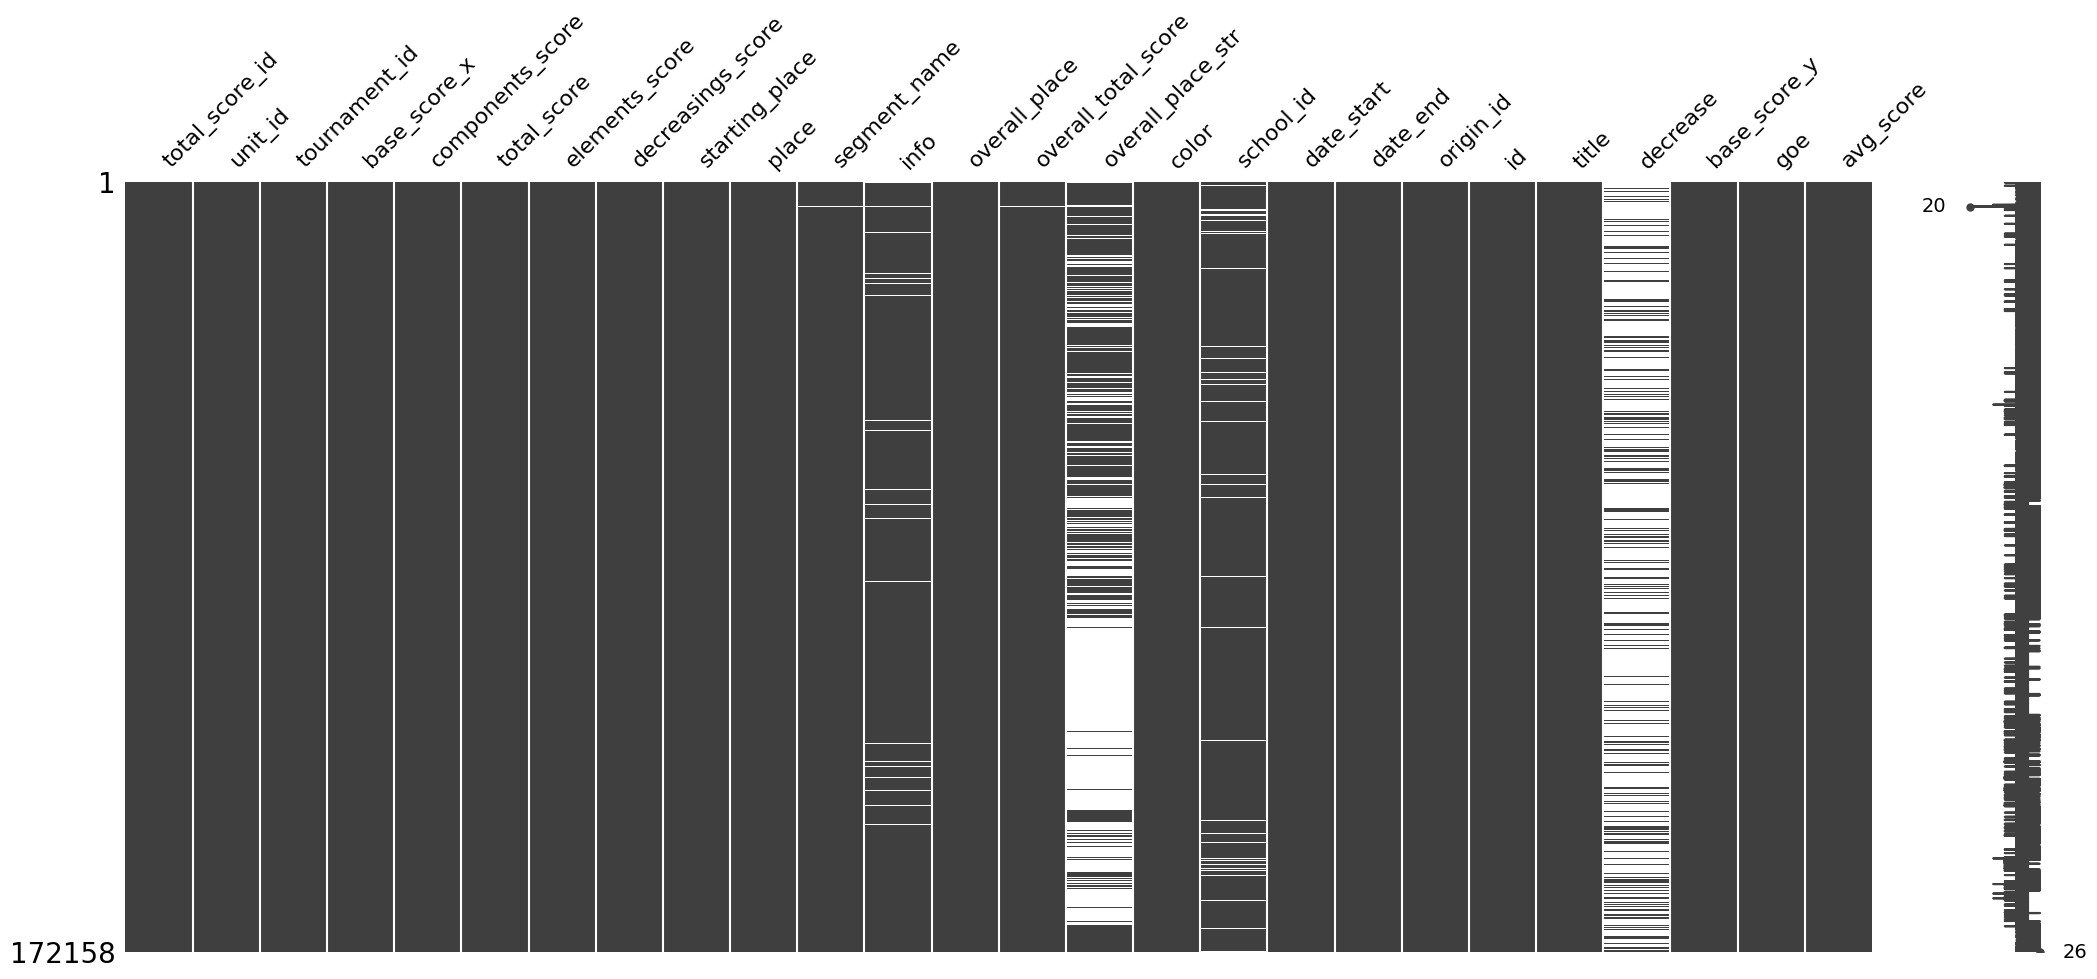

In [18]:
msno.matrix(df_total)

In [19]:
df_total[['any_1','any_2','any_3','any_4','any_5']] = df_total['title'].str.split('+',expand=True)


In [20]:
df_total.segment_name = df_total.segment_name.replace(
    {'Короткая программа': 'Short',
     'Кoроткая программа': 'Short',
     'Кopoткaя пpoгpaммa': 'Short',
     'Коpоткая программа': 'Short',
     'Kopoткaя пpoгpaммa': 'Short',
     'Произвольная программа': 'Arbitrary',
     'Произвольная программа.': 'Arbitrary',
     'Произвольнaя программа': 'Arbitrary',
     'Пpoизвoльнaя пpoгpaммa': 'Arbitrary',
     'Пpoизвольная программа': 'Arbitrary',
     'Пpoизвольнaя программа': 'Arbitrary',
     'Прoизвольная прoграмма': 'Arbitrary',
     'Элементы': 'Elements',
     'Интерпретация': 'Elements',
     'Элeмeнты': 'Elements',
     'Прыжки': 'Elements',
     'Интерпретация.': 'Elements'}
)
df_total.segment_name.unique()

array(['Short', 'Arbitrary', 'Elements', nan], dtype=object)

In [21]:
df_total.segment_name.value_counts(dropna=False)

segment_name
Arbitrary    111892
Short         55387
Elements       4836
NaN              43
Name: count, dtype: int64

In [22]:
df_total[df_total.unit_id==1573][['title','any_1','any_2','any_3','any_4','any_5']]

,title,any_1,any_2,any_3,any_4,any_5
117183,2A,2A,None,None,None,None
117184,3S<,3S<,None,None,None,None
117185,CCoSp4,CCoSp4,None,None,None,None
117186,3Lo<<+2T,3Lo<<,2T,None,None,None
117187,StSq2,StSq2,None,None,None,None
117188,FCSp3,FCSp3,None,None,None,None
117189,LSp4,LSp4,None,None,None,None
117331,2A,2A,None,None,None,None
117332,3Lo<,3Lo<,None,None,None,None
117333,2T,2T,None,None,None,None


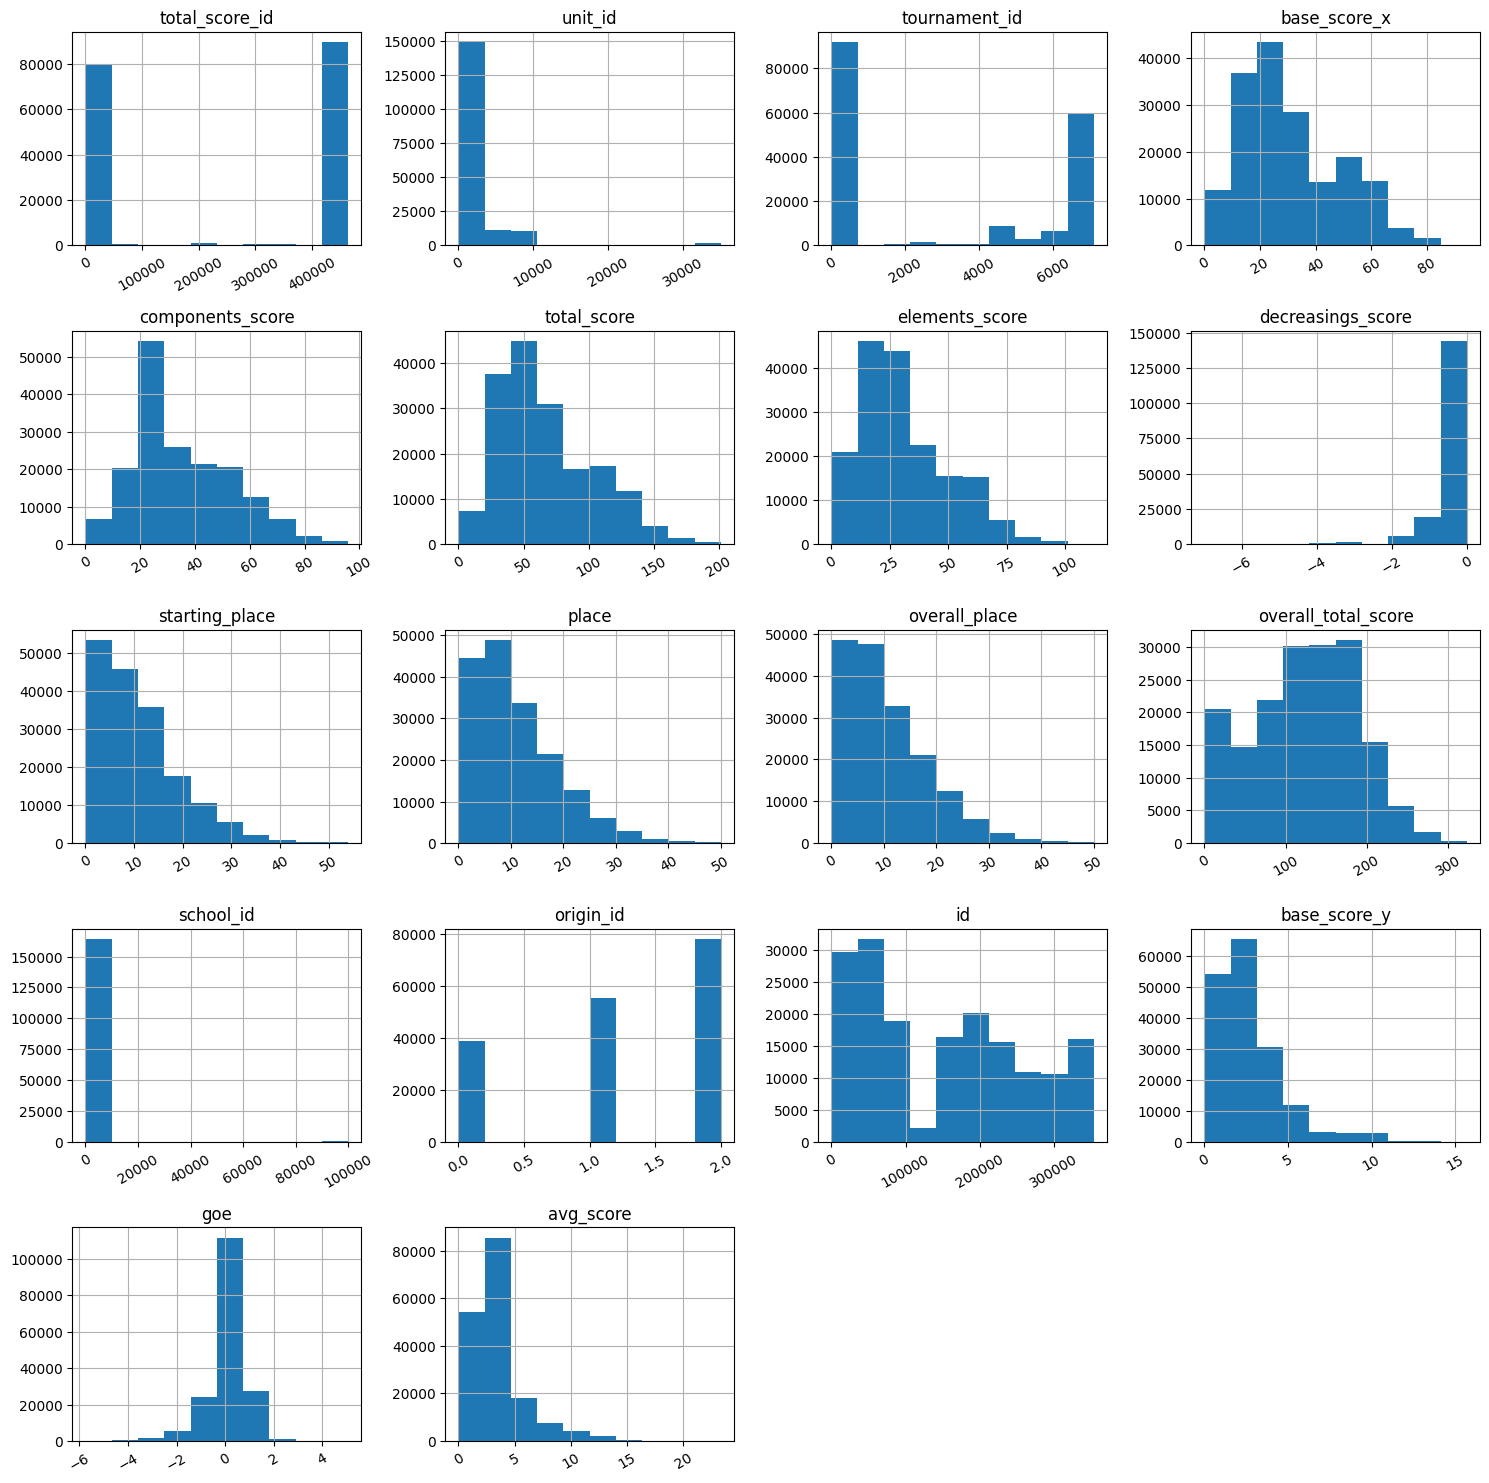

In [25]:
df_total.hist(figsize=(15,15), xrot=30)
plt.tight_layout()
plt.show()

In [26]:
title_list = list(df_total['title'].dropna().unique())
title_list.sort(key=lambda x: x[:2])
title_list

['1A',
 '1A+1Lo',
 '1A+COMBO+1Lo*',
 '1A+1T',
 '1A+1A+SЕQ',
 '1Aq+1Lo',
 '1A<<',
 '1A*',
 '1A+2T',
 '1A+2Lo',
 '1A+SEQ+1Lo*',
 '1Aq',
 '1A<<+SEQ+1Lo<*',
 '1A<',
 '1A<+SEQ+1Lo*',
 '1A+REP',
 '1A*+REP',
 '1A*+COMBO',
 '1A<<*',
 '1A+1Lo*+REP',
 '1A+COMBO+1Lo<*',
 '1A<+1Lo',
 '1A<+1Loq',
 '1A+1Loq',
 '1A+1Eu+3S<',
 '1A+1Eu+3S<<',
 '1A+1Eu+2S',
 '1A+1Eu+3S',
 '1A+2Loq',
 '1A+2Lo<',
 '1A<<*+REP',
 '1A+1Lo<',
 '1A+1Lo<<',
 '1A+COMBO+1T*',
 '1Aq*',
 '1A+2T<',
 '1Aq+1Lo<',
 '1A<<+1T',
 '1A<<+1Lo',
 '1A+COMBO+1Lo*+REP',
 '1Aq+COMBO+1Lo*',
 '1Aq+REP',
 '1A+2Lo<<',
 '1A+1Lo<<+1Lo*',
 '1A*+1Lo*',
 '1A*+1Lo*+REP',
 '1A<*',
 '1A<<*+COMBO*',
 '1A+COMBO+1Lo',
 '1A<+REP',
 '1A<<+COMBO+1Lo*',
 '1Aq+1Loq',
 '1A+Lo',
 '1A+1Lo<<*',
 '1A*+2T*',
 '1A+3T',
 '1A<<+REP',
 '1A+COMBO+3S*',
 '1A+1T<<',
 '1A+1T*+REP',
 '1A*+1Eu+2S',
 '1A+1Eu+1S',
 '1A+2Tq',
 '1A+2T*',
 '1A+2T<<',
 '1A+1Eu+3Sq',
 '1A+1Lo*+2Lo*',
 '1A+1A+SEQ',
 '1A<+1T',
 '1A+1Lo<<*+REP',
 '1A<+SEQ+1A*',
 '1A+Lo*',
 '1A+1Eu+2F!q',
 '1A<+COMBO+1Lo*',
 

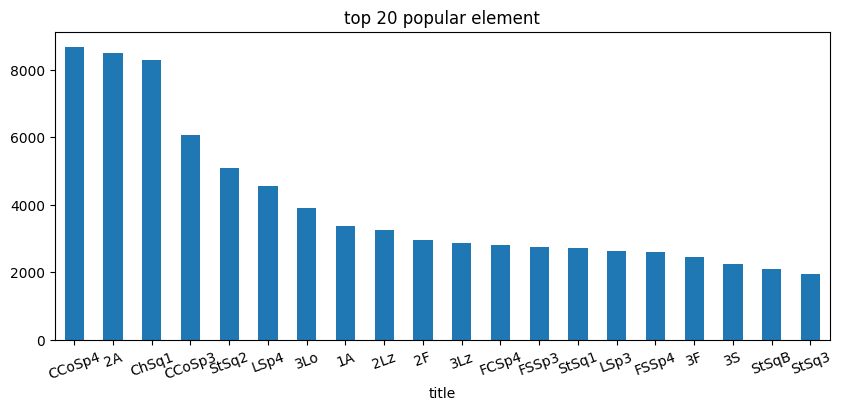

In [27]:
df_total['title'].value_counts(dropna=False).head(20).plot(kind='bar', rot=20, figsize=(10,4))
plt.title('top 20 popular element')
plt.show()

Определяем целевой признак как 1-чисто выполнен элемент, 0-выполнен грязно или вообще незасчитан.

In [28]:
search_values = ['q', '<', '!', '<<', 'nS', 'F', '*', 'e', 'nU', 'nC', '<<*', '<*', 'B', 'nS*', '!F',
 'F*', '!*', 'q*', 'e*', 'nF', 'nB', 'B.', 'f*', 'В', '<F', 'qF', 'b', '!<', 'f', '!F*',
 'FnU', 'FF']

In [29]:
df_total['target'] = df_total['decrease'].apply(lambda x: 0 if x in search_values else 1)

In [30]:
df_total['target']

0         1
1         1
2         1
3         1
4         1
         ..
172153    1
172154    1
172155    0
172156    1
172157    0
Name: target, Length: 172158, dtype: int64

In [31]:
df_total.target.value_counts(dropna=False)

target
1    130973
0     41185
Name: count, dtype: int64

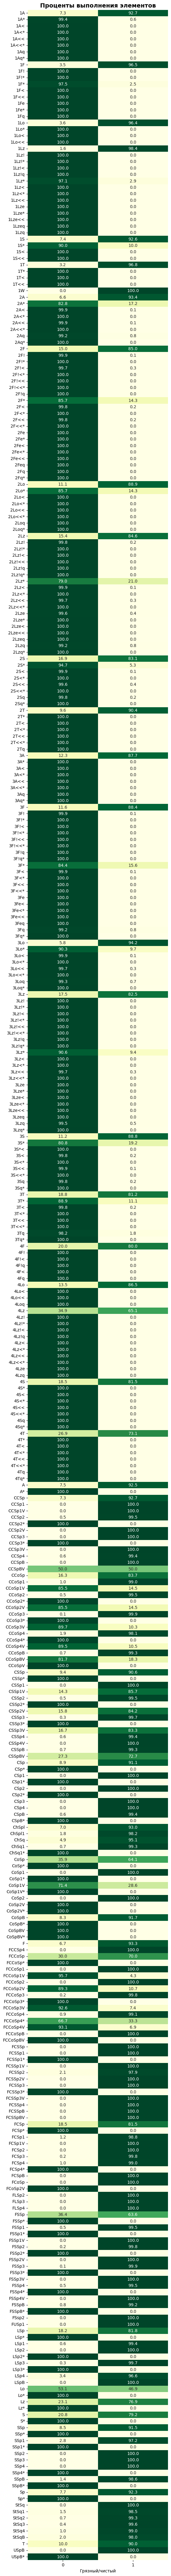

In [59]:
cross_tab = pd.crosstab(df_total['any_1'], df_total['target'], normalize='index') * 100

# Create a heatmap using seaborn
plt.figure(figsize=(6, 110))
sns.heatmap(cross_tab, annot=True, cmap= "YlGn",fmt='.1f', cbar=False)
plt.xlabel('Грязный/чистый')
plt.yticks(rotation=0)
plt.ylabel('')
plt.title('Проценты выполнения элементов', size=14, weight="bold")
plt.show()

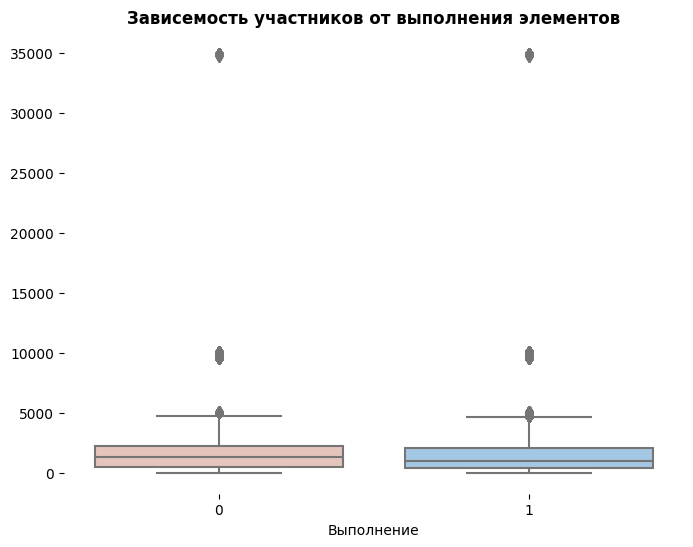

In [60]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_total, x='target', y='unit_id', orient='v', palette = ["#ebc1b7", "#9ac8ed"])
plt.xlabel('Выполнение')
plt.ylabel("")
plt.title('Зависемость участников от выполнения элементов', size=12, weight="bold")
sns.despine(left=True, bottom=True)
plt.show()

In [34]:
Q1 = df_total['unit_id'].quantile(0.25)
Q3 = df_total['unit_id'].quantile(0.75)
IQR = Q3 - Q1

# Определите нижнюю и верхнюю границы для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

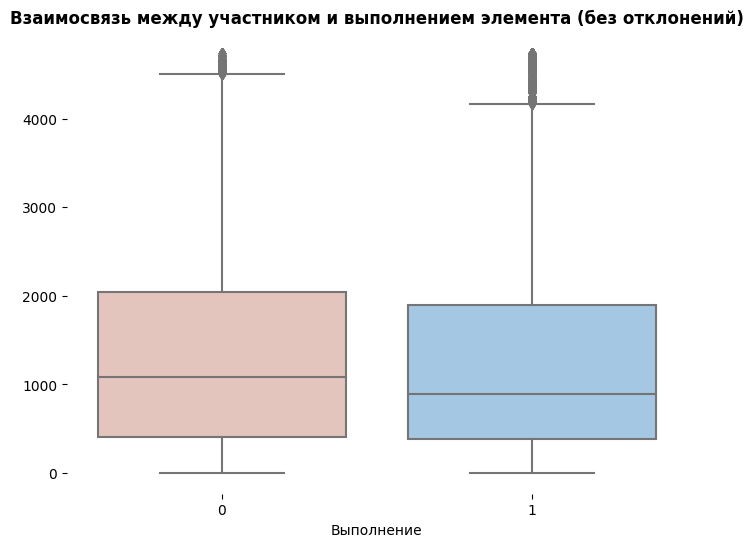

In [61]:
df1 = df_total[(df_total['unit_id'] >= lower_bound) & (df_total['unit_id'] <= upper_bound)]
plt.figure(figsize=(8, 6))
sns.boxplot(data=df1, x='target', y='unit_id', orient='v',palette = ["#ebc1b7", "#9ac8ed"])
plt.ylabel('Количество')
plt.xlabel('Выполнение')
plt.ylabel("")
plt.title('Взаимосвязь между участником и выполнением элемента (без отклонений)', size=12, weight="bold")
sns.despine(left=True, bottom=True)
plt.show()

In [36]:
df1.drop(['total_score_id','tournament_id','title','place','starting_place','info','overall_place','overall_place_str','school_id','date_start','date_end','origin_id','decrease'], axis=1, inplace=True)

In [37]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157469 entries, 0 to 172131
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   unit_id              157469 non-null  int64  
 1   base_score_x         157469 non-null  float64
 2   components_score     157469 non-null  float64
 3   total_score          157469 non-null  float64
 4   elements_score       157469 non-null  float64
 5   decreasings_score    157469 non-null  float64
 6   segment_name         157469 non-null  object 
 7   overall_total_score  157469 non-null  float64
 8   color                157469 non-null  object 
 9   id                   157469 non-null  int64  
 10  base_score_y         157469 non-null  float64
 11  goe                  157469 non-null  float64
 12  avg_score            157469 non-null  float64
 13  any_1                157469 non-null  object 
 14  any_2                34146 non-null   object 
 15  any_3                1

Заполняем пустоты в данных.

In [38]:
values = {"segment_name": 'Elements', "color": 0}
df1.fillna(value=values)

,unit_id,base_score_x,components_score,total_score,elements_score,decreasings_score,segment_name,overall_total_score,color,id,base_score_y,goe,avg_score,any_1,any_2,any_3,any_4,any_5,target
0,304,47.2,43.47,102.70,59.23,0.0,Short,293.74,lime,156223,11.5,3.78,15.28,4Lz,None,None,None,None,1
1,304,47.2,43.47,102.70,59.23,0.0,Short,293.74,lime,156224,13.9,2.49,16.39,4S,3T,None,None,None,1
2,304,47.2,43.47,102.70,59.23,0.0,Short,293.74,lime,156225,3.2,0.87,4.07,FCSp4,None,None,None,None,1
3,304,47.2,43.47,102.70,59.23,0.0,Short,293.74,lime,156226,0.0,2.40,11.20,3A,None,None,None,None,1
4,304,47.2,43.47,102.70,59.23,0.0,Short,293.74,lime,156227,3.3,0.85,4.15,StSq3,None,None,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172127,1995,23.2,25.50,46.22,21.22,-0.5,Arbitrary,71.27,green,344312,3.0,0.17,3.17,ChSq1,None,None,None,None,1
172128,1995,23.2,25.50,46.22,21.22,-0.5,Arbitrary,71.27,green,344313,0.0,0.00,4.40,2F,1A,1A,SЕQ,None,1
172129,1995,23.2,25.50,46.22,21.22,-0.5,Arbitrary,71.27,green,344314,0.0,-0.78,1.07,2Lze,None,None,None,None,0
172130,1995,23.2,25.50,46.22,21.22,-0.5,Arbitrary,71.27,green,344315,0.0,-0.34,1.53,2Loq,None,None,None,None,0


In [39]:
df1=df1.fillna(0)

In [40]:
df1

,unit_id,base_score_x,components_score,total_score,elements_score,decreasings_score,segment_name,overall_total_score,color,id,base_score_y,goe,avg_score,any_1,any_2,any_3,any_4,any_5,target
0,304,47.2,43.47,102.70,59.23,0.0,Short,293.74,lime,156223,11.5,3.78,15.28,4Lz,0,0,0,0,1
1,304,47.2,43.47,102.70,59.23,0.0,Short,293.74,lime,156224,13.9,2.49,16.39,4S,3T,0,0,0,1
2,304,47.2,43.47,102.70,59.23,0.0,Short,293.74,lime,156225,3.2,0.87,4.07,FCSp4,0,0,0,0,1
3,304,47.2,43.47,102.70,59.23,0.0,Short,293.74,lime,156226,0.0,2.40,11.20,3A,0,0,0,0,1
4,304,47.2,43.47,102.70,59.23,0.0,Short,293.74,lime,156227,3.3,0.85,4.15,StSq3,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172127,1995,23.2,25.50,46.22,21.22,-0.5,Arbitrary,71.27,green,344312,3.0,0.17,3.17,ChSq1,0,0,0,0,1
172128,1995,23.2,25.50,46.22,21.22,-0.5,Arbitrary,71.27,green,344313,0.0,0.00,4.40,2F,1A,1A,SЕQ,0,1
172129,1995,23.2,25.50,46.22,21.22,-0.5,Arbitrary,71.27,green,344314,0.0,-0.78,1.07,2Lze,0,0,0,0,0
172130,1995,23.2,25.50,46.22,21.22,-0.5,Arbitrary,71.27,green,344315,0.0,-0.34,1.53,2Loq,0,0,0,0,0


In [41]:
df1.color.value_counts(dropna=False)

color
green    111916
lime      45553
Name: count, dtype: int64

In [42]:
df1.isna().sum()

unit_id                0
base_score_x           0
components_score       0
total_score            0
elements_score         0
decreasings_score      0
segment_name           0
overall_total_score    0
color                  0
id                     0
base_score_y           0
goe                    0
avg_score              0
any_1                  0
any_2                  0
any_3                  0
any_4                  0
any_5                  0
target                 0
dtype: int64

In [43]:
cat_cols = df1.select_dtypes('object').columns.tolist()
if not cat_cols:
    cat_cols = df1.select_dtypes('category').columns.tolist()

In [44]:
cat_cols

['segment_name', 'color', 'any_1', 'any_2', 'any_3', 'any_4', 'any_5']

Проводим кодирование строковых данных.

In [46]:
OE = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [45]:
df1[cat_cols] = df1[cat_cols].astype(str)

In [47]:
df1[cat_cols] = OE.fit_transform(df1[cat_cols])

In [49]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 157469 entries, 0 to 172131
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   unit_id              157469 non-null  int64  
 1   base_score_x         157469 non-null  float64
 2   components_score     157469 non-null  float64
 3   total_score          157469 non-null  float64
 4   elements_score       157469 non-null  float64
 5   decreasings_score    157469 non-null  float64
 6   segment_name         157469 non-null  float64
 7   overall_total_score  157469 non-null  float64
 8   color                157469 non-null  float64
 9   id                   157469 non-null  int64  
 10  base_score_y         157469 non-null  float64
 11  goe                  157469 non-null  float64
 12  avg_score            157469 non-null  float64
 13  any_1                157469 non-null  float64
 14  any_2                157469 non-null  float64
 15  any_3                1

Вывод:
- данные подготовлены и готовы к работе.

In [50]:
X = df1.drop(['target'], axis=1)
y = df1['target']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30 , random_state=12345)

Расмотрим две модели: LogisticRegression() и RandomForestClassifier().

In [52]:
regression_model = LogisticRegression()
regression_model.fit(X_train, y_train)

LogisticRegression()

In [53]:
rfcl = RandomForestClassifier(n_estimators = 50, random_state=12345)
rfcl = rfcl.fit(X_train, y_train)

0.7663046929573887


<Axes: >

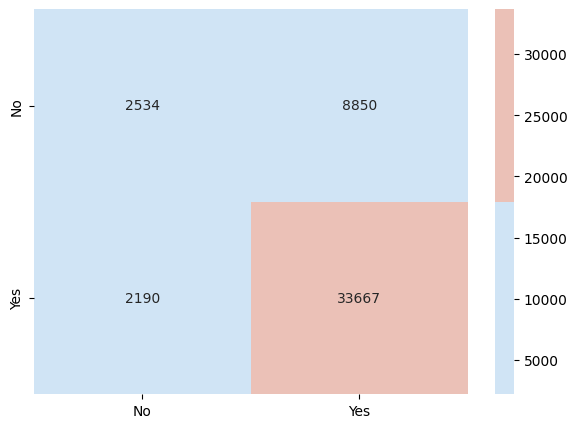

In [54]:
y_predict = regression_model.predict(X_test)
print(regression_model.score(X_test, y_test))
cm=metrics.confusion_matrix(y_test, y_predict,labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, cmap=["#d0e4f5", "#ebc1b7"],annot=True ,fmt='g')

In [55]:
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Precision: 0.7918479666956747
Recall: 0.9389240594584042
F1-Score: 0.8591369586852783


0.9771596706250926


<Axes: >

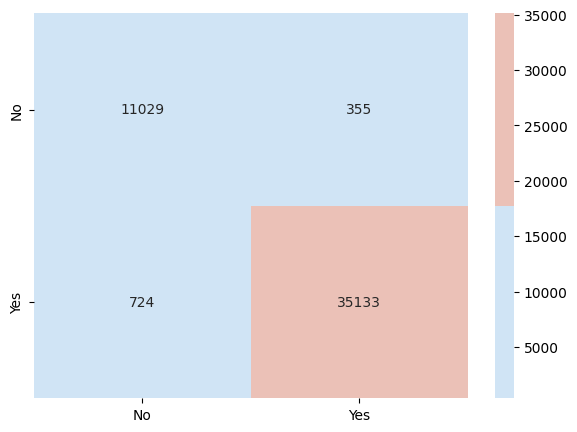

In [56]:
y_predict = rfcl.predict(X_test)
print(rfcl.score(X_test, y_test))
cm=metrics.confusion_matrix(y_test, y_predict,labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, cmap=["#d0e4f5", "#ebc1b7"],annot=True ,fmt='g')

In [57]:
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Precision: 0.9899966185752931
Recall: 0.979808684496751
F1-Score: 0.9848763052771743


Вывод:

LogisticRegression() получили результат:
- Рrecision: 0.7918479666956747
- Recall: 0.9389240594584042
- F1-Score: 0.8591369586852783

RandomForestClassifier() получили результат:
- Precision: 0.9899966185752931
- Recall: 0.979808684496751
- F1-Score: 0.9848763052771743

Модель RandomForestClassifier() показала лучший результат, на тестовых данных - 0,98.

